In [1]:
import json
import xtrack as xt
import xpart as xp
import xobjects as xo
import PyNAFF
from matplotlib import pyplot as plt
import numpy as np

context = xo.ContextCpu()

#with open('../data/collider_thin.json') as f:
#    dct = json.load(f)

#line = xt.Line.from_dict(dct['lines']['lhcb1'])
#line_edited =line.copy()

collider = xt.Multiline.from_json('../data/collider_thin.json')

line = collider['lhcb1']
for ii in line.elements:
   # if ii is a type 'multipole' 
    if type(ii) == xt.beam_elements.elements.Multipole:
        if len(ii.knl)>2:
            #print(ii)
            ii.knl[2] = 0

line.vars['i_oct_b1'] = 0
#line.vars['i_sext_b1'] = 0

line_edited = line.copy()
plt.close('all')

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           


In [2]:
#Only one particle
my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
line.particle_ref = my_particle
num_turns = 1000
sampling_frequency = 11245.5

num_particles = 3
monitor_ip3 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
monitor_ip5 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
monitor_ip8 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
line.insert_element(index='ip3', element=monitor_ip3, name='mymon3')
line.insert_element(index='ip5', element=monitor_ip5, name='mymon5')
line.insert_element(index='ip8', element=monitor_ip8, name='mymon8')




line.build_tracker()


monitor = xt.ParticlesMonitor(_context=context,
                              start_at_turn=0, stop_at_turn=num_turns,
                              num_particles=num_particles)
line.track(my_particle, num_turns=num_turns, freeze_longitudinal=True)

aux = line.twiss()

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_longitudinal`.


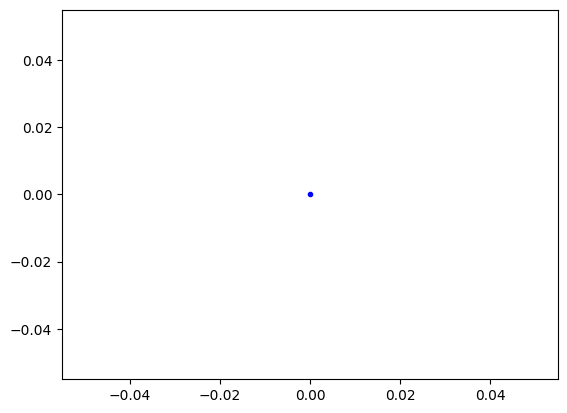

In [3]:
plt.plot(my_particle.x, my_particle.px, '.b') 

In [4]:
monitors = {}  # Create an empty dictionary to store the monitors
#num_particles = 2
#num_turns = 50
line_edited.discard_tracker()
for jj, ii in enumerate((['ip3']+list(aux[:, 'bpm.*']['name']))):
    print(ii)
    monitor_name = f"mymon_{ii.replace('.', '_')}"
    print(monitor_name=='bpm.8r6.b1')
    monitors[monitor_name] = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, num_particles=num_particles)
    line_edited.insert_element(index=ii,
                                element=monitors[monitor_name], 
                                name=monitor_name)
                            



ip3
False
bpmw.4r3.b1
False
bpmwe.4r3.b1
False
bpmw.5r3.b1
False
bpmwj.a5r3.b1
False
bpmwc.6r3.b1
False
bpmr.6r3.b1
False
bpm_a.7r3.b1
False
bpm.8r3.b1
False
bpm.9r3.b1
False
bpm.10r3.b1
False
bpm.11r3.b1
False
bpm.12r3.b1
False
bpm.13r3.b1
False
bpm.14r3.b1
False
bpm.15r3.b1
False
bpm.16r3.b1
False
bpm.17r3.b1
False
bpm.18r3.b1
False
bpm.19r3.b1
False
bpm.20r3.b1
False
bpm.21r3.b1
False
bpm.22r3.b1
False
bpm.23r3.b1
False
bpm.24r3.b1
False
bpm.25r3.b1
False
bpm.26r3.b1
False
bpm.27r3.b1
False
bpm.28r3.b1
False
bpm.29r3.b1
False
bpm.30r3.b1
False
bpm.31r3.b1
False
bpm.32r3.b1
False
bpm.33r3.b1
False
bpm.34r3.b1
False
bpm.33l4.b1
False
bpm.32l4.b1
False
bpm.31l4.b1
False
bpm.30l4.b1
False
bpm.29l4.b1
False
bpm.28l4.b1
False
bpm.27l4.b1
False
bpm.26l4.b1
False
bpm.25l4.b1
False
bpm.24l4.b1
False
bpm.23l4.b1
False
bpm.22l4.b1
False
bpm.21l4.b1
False
bpm.20l4.b1
False
bpm.19l4.b1
False
bpm.18l4.b1
False
bpm.17l4.b1
False
bpm.16l4.b1
False
bpm.15l4.b1
False
bpm.14l4.b1
False
bpm.13l4.b1
Fal

In [5]:
# Exciter is working


f = 10
phi = 0
A = 1
sampling_frequency = 11245.5
total_time = num_turns / sampling_frequency
time = np.arange(0, total_time, 1/sampling_frequency)
samples = A * np.sin(2*np.pi*f*time + phi)


exciter = xt.Exciter(_context = context,
    samples = samples,
    sampling_frequency = sampling_frequency,
    duration = 0.05,  # defaults to waveform duration   in sec, checked with the number of turns 0.05*11245.5=562.275
    frev = sampling_frequency,
    start_turn = num_turns/10,  # default, seconds
    knl = [0.00000001],  # default, no kick
     # default, no kick
    #knl = [1],
    #ksl = []
)
print(dir(line_edited.insert_element))

# Add it to the line for tracking as usual
'''
for i in range(0, num_turns):
    while i < num_turns:
        line.insert_element(
            element = exciter,
            name = 'RF_KO_EXCITER',
            index = 42,
        )
        i += 1    
'''


line_edited.insert_element(
    element = exciter,
    name = 'RF_KO_EXCITER',
    index = 42,
)

#insertion of the element in the beamline, the phase should be broken due to the kick



['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [6]:

line_edited.particle_ref = my_particle
line_edited.discard_tracker()
line_edited.build_tracker()
#print(line_edited.twiss()[:,'mymon_.*'])
#len(line_edited.twiss()[:,'mymon_.*']['mux'])


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [7]:
# generates a matched gaussian bunch and tracks it through the line
# the line is then edited to include BPMs and the bunch is tracked again
# the BPMs are then used to calculate the emittance of the bunch
# 
particles = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)#, x=[0.003, 0.002, 0.001])

particle_0 = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)#, x=[0.003, 0.002, 0.001])
#particle_0 = xp.Particles(
                 #   mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x=0.003)

#particles = xp.generate_matched_gaussian_bunch(line=line,
                                           #    num_particles=num_particles,
                                           #    nemitt_x=2.5e-6,
                                           #    nemitt_y=2.5e-6,
                                           #    sigma_z=9e-2, particle_ref=particles)
line_edited.track(particles, num_turns=num_turns, freeze_longitudinal=True)


Compiling ContextCpu kernels...


Done compiling ContextCpu kernels.


In [8]:
line_edited.get_s_position(at_elements='mymon_bpmw_4l3_b1')

26636.4387

Text(0, 0.5, 'px [rad]')

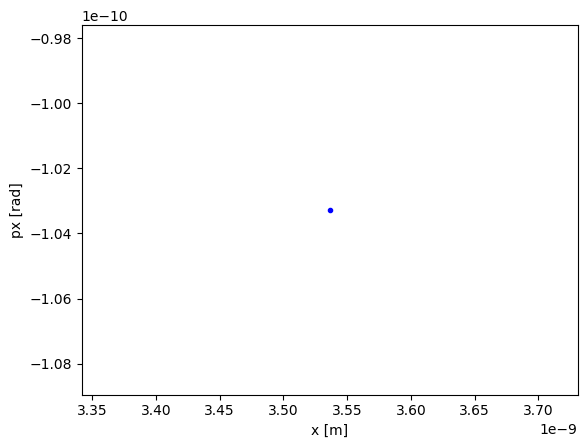

In [9]:
plt.plot(particles.x, particles.px, '.b')
plt.xlabel('x [m]')
plt.ylabel('px [rad]')

15000
1000


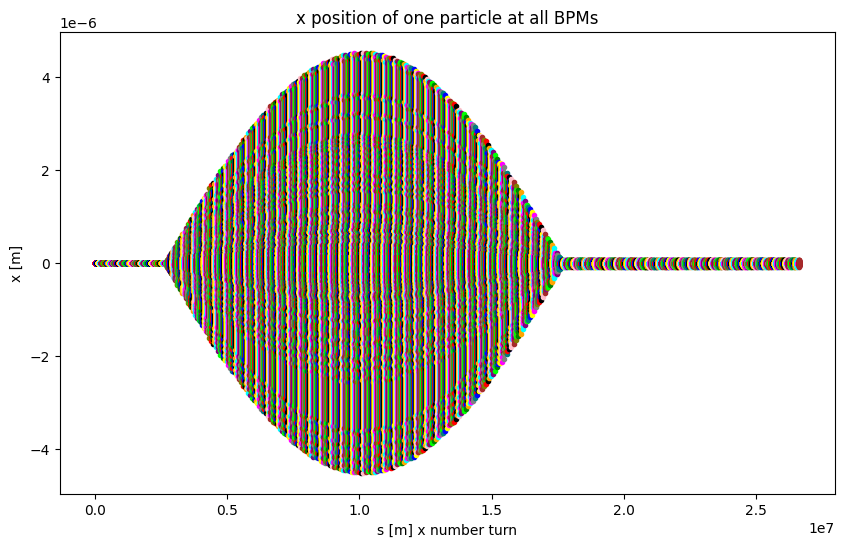

In [10]:

plt.figure(figsize=(10, 6))
#s_list = [monitors[ii].s[0,0] for ii in monitors]
#print(s_list[0])
#for jj in range(len(monitors)
n = np.arange(0, num_turns)
twiss = line_edited.twiss()
mux = twiss[:,'mymon.*'].mux
betx = twiss[:,'mymon.*'].betx
#print(betx)
#print(len(twiss['mux']))
#mux = twiss.mux
#print(len(mux))
#print(n)
x_list_all = []
x_list0 = []  
s_list0 = []
x_list_norm = []
c = 1000*['red', 'green', 'blue', 'black', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'brown', 'purple', 'gray', 'olive', 'lime', 'teal']
print(len(c))
for jj in n:
    #print(jj)
    x_list = [monitors[ii].x[0,jj] for ii in monitors]   #monitors[ii].x[i,j], i is the particle number, j is the turn number

    #x_list0 = [monitors[ii].x[0,0] for ii in monitors]
    s_list = [monitors[ii].s[0,jj] for ii in monitors]
    x_list_all.extend(x_list)
    x_list_norm.extend(x_list/np.sqrt(betx))


    #print(len(x_list_all))
    mon = monitors['mymon_ip3'].x[0,jj]  #just the first particle, one monitor for all turns
    mon_position = monitors['mymon_ip3'].s[0,jj]    
    #mux = twiss[:,'mymon_ip3'].mux
    #print(mux)
    x_list0.append(mon)  
    s_list0.append(mon_position) #

    #print(s_list)
    #plt.plot(s_list+(jj)*s_list[-1], x_list, '.-r')
    plt.plot((s_list + jj*s_list[-1]), x_list, '.-', color=c[jj])
    
    
    #plt.plot(mux, x_list/np.sqrt(betx), '.-r')
    #plt.xlim(0,4)

    
#plt.plot(s_list, x_list0, 1'.-b')
#print(s_list0)
x = np.fft.fft(x_list_all)

plt.xlabel('s [m] x number turn')
plt.ylabel('x [m]')
plt.title('x position of one particle at all BPMs')
print(len(x_list0))
plt.show()

#fft_try = abs(np.fft.fft(x_list0 - np.mean(x_list0)))
fft_try = np.fft.fft(x_list0) # fft of one monitor for all turns
fft_try = fft_try/len(fft_try)*2 #normalization
fft = fft_try.real + 1j*fft_try.imag 
# 
fft_used = abs(fft) - np.mean(abs(fft))
#freq_try = np.fft.fftfreq(len(fft_used), d = 1/len(fft_used))
#freq_try = np.fft.fftfreq(len(x_list0), d = 1/len(x_list0))

freq_try  =  np.linspace(0, sampling_frequency, len(fft_used))

plt.show()




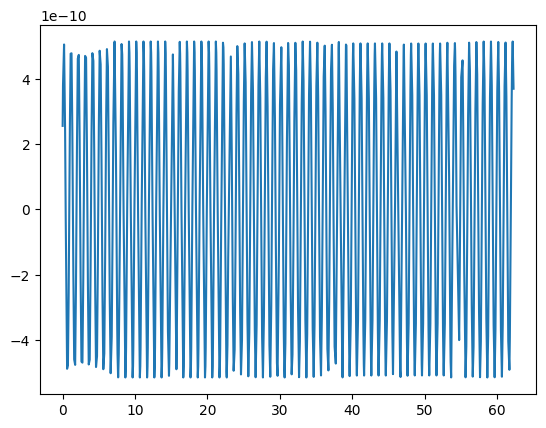

In [11]:
len(x_list/np.sqrt(betx))
plt.plot(mux, x_list/np.sqrt(betx))

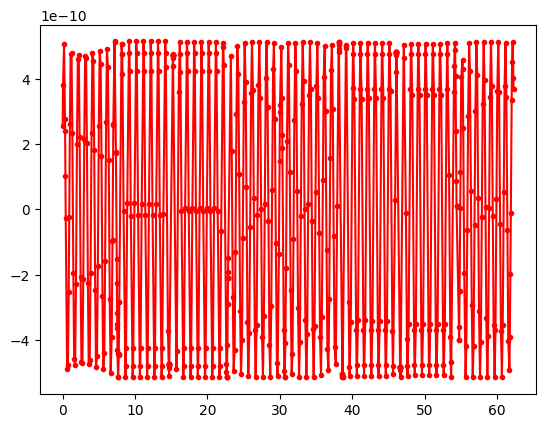

In [12]:
plt.plot(mux, x_list/np.sqrt(betx), '.-r')

Text(0, 0.5, 'x [m]')

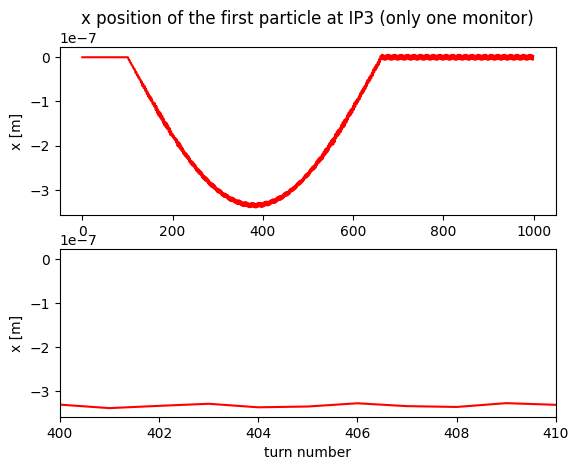

In [13]:
plt.subplot(2,1,1)
plt.title('x position of the first particle at IP3 (only one monitor)')
plt.plot(np.arange(num_turns), x_list0, '-r') 
plt.ylabel('x [m]')
plt.subplot(2,1,2)
plt.plot(np.arange(num_turns), x_list0, '-r')
plt.xlim(400, 410)
plt.xlabel('turn number')
plt.ylabel('x [m]')


amplitude_fit -6.723186392528012e-09
frequency_fit 0.9997812855700072


/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


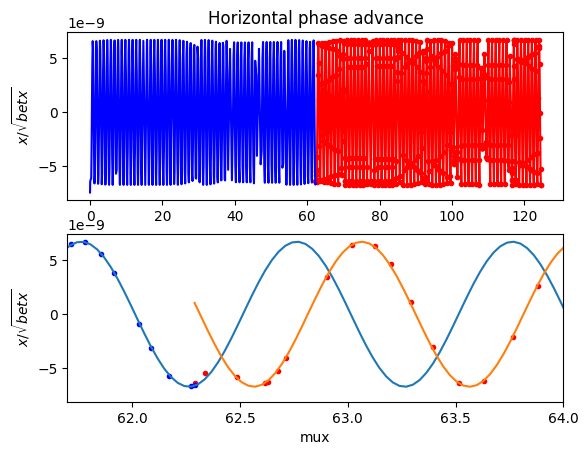

In [81]:
# Data for only the first turn, all BPMs
#print('betx', betx)
#y_data = x_list_all[len(mux)+1:len(mux)*2+1]/np.sqrt(betx)
#y_data_1 = x_list_all[0:len(mux)]/np.sqrt(betx)
mux = twiss[:,'mymon.*'].mux
n= -100

#y_data_1 = x_list_all[len(mux)*int(num_turns/2+2):len(mux)*int(num_turns/2+3)]/np.sqrt(betx)
#y_data = x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx)
#y_data_0 = x_list_all[len(mux)*int(num_turns/2+0):len(mux)*int(num_turns/2+1)]/np.sqrt(betx)
y_data_0 = x_list_all[len(mux)*int(721+n):len(mux)*int(722+n)]/np.sqrt(betx)
y_data = x_list_all[len(mux)*int(722+n):len(mux)*int(723+n)]/np.sqrt(betx)
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

# Fit the sine function to the data
initial_guess = [1, 1, 0, 1]  # Initial guess for the parameters
fit_params, _ = curve_fit(sine_function, mux, y_data_0, p0=initial_guess)
fit_params1, _1 = curve_fit(sine_function, mux, y_data, p0=initial_guess)
# Extract the fitted parameters
amplitude_fit, frequency_fit, phase_fit, offset_fit = fit_params
amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1 = fit_params1

x_fine = np.linspace(min(mux), 2 * max(mux), 4000)
# Generate the fitted curve using the fitted parameters
y_fit = sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit)
y_fit1 = sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1)

fitted_sine_interpolated = interp1d(x_fine, sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit))
fitted_sine_interpolated1 = interp1d(x_fine, sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1))
y_fine = fitted_sine_interpolated(x_fine)
y_fine_1 = fitted_sine_interpolated1(x_fine)


plt.subplot(2,1,1)

#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
plt.plot(mux+mux[-1], y_data, '.-r')
plt.plot(mux, y_data_0, '-b')
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(x_fine, y_fine)
#plt.xlim(0,10)
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
plt.title('Horizontal phase advance')
plt.ylabel('$x/\sqrt{betx}$')
plt.subplot(2,1,2)
#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
#plt.plot(mux, y_data, '.-r')#
plt.plot(mux + mux[-1], y_data, '.r')
plt.plot(mux, y_data_0, '.b')
plt.plot(x_fine, y_fine)
plt.plot(x_fine+x_fine[-1]/2, y_fine_1)
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
#plt.xlim(mux[-1]*2-mux[10], mux[-1]*2+ mux[10])
plt.xlim(61.7, 64)
#plt.xlim(0,10)
#print('mux', twiss[:,'mymon.*'].mux)
#print('len mux', len(twiss[:,'mymon.*'].mux))
#print('twiss.mux', len(twiss.mux))

plt.xlabel('mux')
plt.ylabel('$x/\sqrt{betx}$')
print('amplitude_fit', amplitude_fit)
print('frequency_fit', frequency_fit)



# Localization of the broken phase
 - One can find a period where the phase is not broken and fit the function, then one extends the fit for all the data and looks where the error grows.
 - Due to the small number of data points (BPMs) a more fine grid is implemented and the closest phase value localized.
 - This value is then compared to the horizontal displacement and the fit horizontal displacement without a broken phase
 - Clearly the breaking in the phase can be seen exactly as expected

y_diff [ 3.45018804e-10  6.24892693e-10 -4.90803423e-09 -1.04632338e-08
 -1.02875604e-08 -1.10689635e-08 -1.04208208e-08 -1.01792303e-09
  6.74062766e-09  1.03479912e-08  1.09550317e-08  7.70550530e-09
  1.47323780e-09 -6.60027319e-09 -1.11222907e-08 -8.81848429e-09
 -1.99245217e-09  6.60580456e-09  1.10911044e-08  8.79056059e-09]
y_diff0 [-7.40290695e-09 -3.80101030e-09  6.88055240e-12  1.20920112e-10
 -2.52054591e-10  8.70582936e-11 -7.31545998e-10 -5.02321983e-10
  5.20819625e-11  3.52720274e-10  1.28952004e-10  1.79125581e-10
  8.26499009e-10 -5.23112695e-12 -1.28036492e-10  2.46343561e-10
 -1.64588202e-10 -8.94297227e-11  9.84224392e-11  9.53368200e-10]
1136
1136


Text(0, 0.5, '$x/\\sqrt{betx}$ - $x_{fit}$')

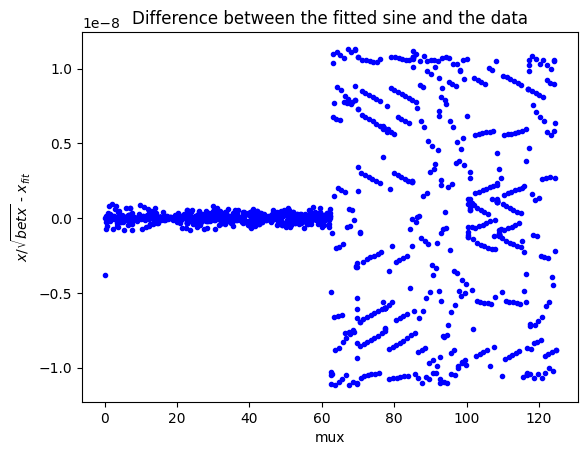

In [80]:
#% find the closest x_fine value to mux

closest_ind_all = []
x_close_all = []
y_close_all = []
y_diff = []
y_diff0 = []
mux = twiss[:,'mymon.*'].mux
mux = np.append(mux, mux + mux[-1])
for i in range(len(mux)):
    y_close = []
    closest_ind = []
    x_close = []
    closest_ind = np.argmin(np.abs(x_fine - (mux[i])))
    closest_ind_all.append(closest_ind)
    x_close = x_fine[closest_ind]
    x_close_all.append(x_close)
    y_close = y_fine[closest_ind]
    y_close_all.append(y_close)
    
y_diff_all = []
y_diff = y_data - y_close_all[len(y_data):]
y_diff0 = y_data_0 - y_close_all[:len(y_data)]
y_diff_all = np.append(y_diff0, y_diff)
    
#print('closest_ind_all', closest_ind_all)
#print('y_close', y_close_all)
#print(len(y_close_all))


print('y_diff', y_diff[:20])
print('y_diff0', y_diff0[:20])
print(len(closest_ind_all))
print(len(mux))
for i in range(len(y_diff_all)):
    if i > 1e-10:
        plt.plot(mux[i], y_diff_all[i], '.b')
plt.title('Difference between the fitted sine and the data')
plt.xlabel('mux')
plt.ylabel('$x/\sqrt{betx}$ - $x_{fit}$')





# Phase advance between the signals

In [ ]:
# Phase advance

568000
[60.54535007 60.6822344  60.79695972 60.93410647 61.04824545 61.18514208
 61.29987138 61.43646687 61.56097568 61.71541276 61.77944838 61.85437561
 61.91403845 62.03045918 62.0875448  62.17090122 62.27427411 62.28947783
 62.28947783 62.33910607 62.48674349 62.61627608 62.62890387 62.67479872
 62.7149366  62.90517067 63.01821211 63.12437992 63.19914327 63.29191185
 63.39558227 63.51669168 63.63122057 63.76812928 63.8820816  64.01866763
 64.13320057 64.27010098 64.38404993 64.52064428 64.63518054 64.77231106
 64.88684734 65.02397786 65.13851413 65.27564466 65.39018093 65.52731146
 65.64184773 65.77897825]
[[ 6.03133377e+03  0.00000000e+00]
 [ 6.03139462e+03  0.00000000e+00]
 [ 6.03143222e+03  0.00000000e+00]
 ...
 [ 6.57905839e+03  7.81983338e-10]
 [ 6.57907421e+03  8.50636531e-10]
 [ 6.57951659e+03 -5.65458883e-10]]


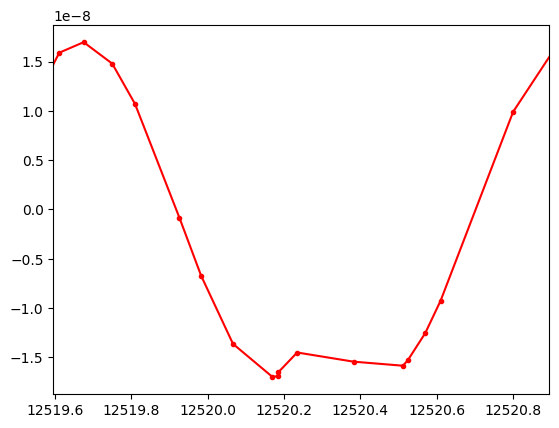

In [37]:
mux_all_list = []
for i in range(num_turns):
    mux_all = mux + i*mux[-1]
    mux_all_list = np.append(mux_all_list, mux_all)
number = 200
print(len(mux_all_list))
used_x = np.array(x_list_norm[len(mux)*number:len(mux)*(number+2)])/1
used_mux = np.array(mux_all_list[len(mux)*number:len(mux)*(number+2)])/1
print(mux_all_list[550:600])
data = np.stack((mux_all_list, x_list_norm))
print(data.T[55000:60000])
plt.plot(used_mux, used_x, '.-r')

plt.xlim(mux_all_list[len(mux)*number]+61.7, mux_all_list[len(mux)*(number)]+63)
#plt.xlim(40250.7, 40300)
#plt.ylim(-0.5e-8, 0.5e-8)
plt.show()

12457.895565781619


/tmp/ipykernel_925/1544622175.py:12: RuntimeWarning: invalid value encountered in sqrt
  return a * np.cos(np.sqrt(x**2-phi_si**2)-np.pi*0.31+c)
/home/aradosla/2023_07_13_test_with_Guido/miniforge/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


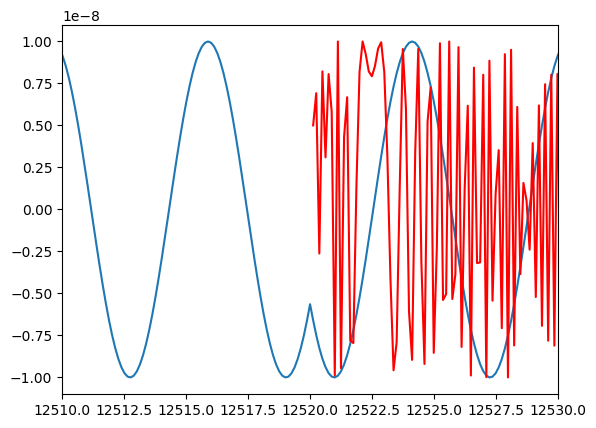

(12510.0, 12530.0)

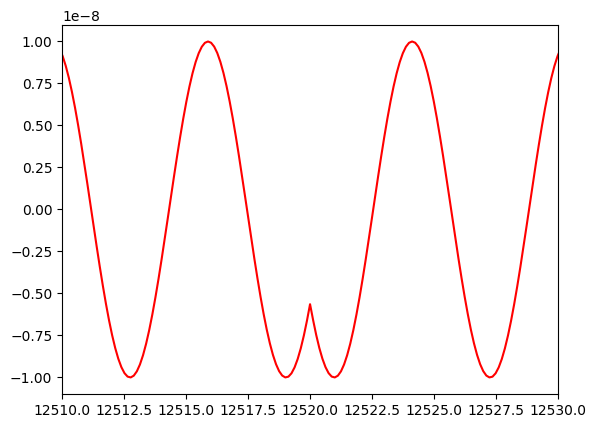

In [153]:
theta = np.linspace(-4,4, 1000)
theta1 = np.linspace(-4,4, 1000)
theta = np.linspace(min(mux_all_list[len(mux)*number:len(mux)*(number+2)]),max(mux_all_list[len(mux)*number:len(mux)*(number+2)]), 1000)
theta = np.linspace(12515, 12525, 100)
print(min(mux_all_list[len(mux)*number:len(mux)*(number+2)]))
c = np.pi
a = 1e-8
phi_si = 12520

f = a * np.cos(abs(theta-phi_si)-np.pi*0.31+c)
plt.plot(theta, f)
def fit_function(x, amp, phase, offset):
    return a * np.cos(np.sqrt(x**2-phi_si**2)-np.pi*0.31+c)
# Fit the sine function to the data
initial_guess = [1,phi_si, c]  # Initial guess for the parameters

#fit_params_cos, _cos = curve_fit(fit_function, mux_all_list[len(mux)*number:len(mux)*(number*2)], x_list_norm[len(mux)*number:len(mux)*(number+2)], p0=initial_guess)
fit_params_cos, _cos = curve_fit(fit_function, used_mux, used_x, p0=initial_guess)
amplitude_fit_cos, phase_fit_cos, offset_fit_cos = fit_params_cos
y_fit_cos = fit_function(theta, amplitude_fit_cos,phase_fit_cos, offset_fit_cos)


#fitted_sine_interpolated = interp1d(x_fine, sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit))
#fitted_sine_interpolated1 = interp1d(x_fine, sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1))
#y_fine = fitted_sine_interpolated(x_fine)
#y_fine_1 = fitted_sine_interpolated1(x_fine)
#plt.xlim(plt.xlim(mux_all_list[len(mux)*number]+61.7, mux_all_list[len(mux)*(number)]+63))
plt.plot(theta, y_fit_cos, '-r')
plt.plot()
plt.xlim(12510,12530)
plt.show()
plt.plot(theta, a * np.cos(abs(theta-phi_si)-np.pi*0.31+c), '-r')
plt.xlim(12510,12530)


In [ ]:
fft_try = np.fft.fft(x_list0)

# Normalize the FFT result
fft_normalized = fft_try / len(fft_try)*2

# Calculate the frequency axis
sampling_frequency = 11245.5 # Adjust this to match your actual sampling frequency
freq_try = np.fft.fftfreq(len(fft_normalized), d=1/sampling_frequency)


# Calculate the amplitude spectrum
fft_amplitude = np.abs(fft_normalized)


# Plot the frequency spectrum
plt.plot(freq_try, fft_amplitude, '.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT, simple FFT low resolution")
plt.xlim(0, sampling_frequency / 2)  # Nyquist frequency
plt.xlim(0,20)

#print('The tune is', freq_try[np.argmax(fft_amplitude)]/sampling_frequency)
print('The 10 Hz is now', freq_try[np.argmax(fft_amplitude)])
plt.show()

In [ ]:
# Zero padding
zero_padding_factor = 20
fft_try = np.fft.rfft(x_list0-np.mean(x_list0), n = len(x_list0) * zero_padding_factor)
#print(len(fft_try))
# Normalize the FFT result
fft_normalized = fft_try / len(fft_try)*2

# Calculate the frequency axis
sampling_frequency = 11245.5 # Adjust this to match your actual sampling frequency
freq_try = np.fft.rfftfreq(len(x_list0) *  zero_padding_factor, d=1/sampling_frequency)
#print(len(freq_try))


# Calculate the amplitude spectrum
fft_amplitude = np.abs(fft_normalized)
#print(fft_amplitude)


# Plot the frequency spectrum
plt.plot(freq_try, fft_amplitude, '.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT with zero padding factor = 20")
#plt.xlim(0.22, 0.4)  # Nyquist frequency
plt.xlim(0,20)  
plt.show()
#print('The tune is', freq_try[np.argmax(fft_amplitude)]/sampling_frequency)
print('10 Hz', freq_try[np.argmax(fft_amplitude[0:1000])])

In [ ]:
twiss.dqx 

In [ ]:
# Kick - a wave that is applied to the signal periodically, we choose a sine wave
phi = 0
f = 10 # Hz
A = 2
t = np.arange(10000)/sampling_frequency  # n = 10000, should be 50 in this case, but then the resolution is too low res =  sampling_frequency / frequency
print(t)
#t = np.linspace(0, 1, 50)
print(n)
kick = A * np.sin(2*np.pi*f*t + phi)
plt.plot(np.arange(10000), kick)

# example of a kick
'''
total_time = n_turns / f_rev
time = np.arange(0, total_time, 1/sampling_freq)
samples = np.sin(2*np.pi*f_ex*time + phi)


exciter = xt.Exciter(_context = ctx,
    samples = samples,
    sampling_frequency = sampling_freq,
    duration = None,  # defaults to waveform duration
    frev = f_rev,
    start_turn = 0,  # default, seconds
    knl = KNL,
    ksl = KSL,
)

# Add it to the line for tracking as usual
line.insert_element(
    element = exciter,
    name = 'RF_KO_EXCITER',
    index = 42,
)

insertion of the element in the beamline, the phase should be broken due to the kick
'''

In [ ]:

#collider.build_trackers()
betx = twiss['betx'][0]
bety = twiss['bety'][0]
normal_emitt_x = 2.5e-6
normal_emitt_y = 2.5e-6

sigma_x = np.sqrt(betx*normal_emitt_x/(particles.gamma0*particles.beta0))[0]
sigma_y = np.sqrt(bety*normal_emitt_y/(particles.gamma0*particles.beta0))[0]
x = np.linspace(sigma_x, 3*sigma_x, 5)
px = np.zeros(5)
y = np.zeros(5)
py = np.zeros(5)
zeta = np.zeros(5)
delta = np.zeros(5)

particles = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x=x)

collider['lhcb1'].track(particles, num_turns=num_turns,
              turn_by_turn_monitor=True)

print(x)

ys = collider['lhcb1'].record_last_track.y
xs = collider['lhcb1'].record_last_track.x
print(xs)
qx_i = []
qy_i = []
for ii in range(len(x)):
    qx_i.append(PyNAFF.naff(xs[ii,:], turns=499)[0][1])
    qy_i.append(PyNAFF.naff(ys[ii,:], turns=499)[0][1])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.plot(qx_i,qy_i,'-o')
plt.plot(x**2/sigma_x**3,qx_i,'-o')
plt.xlabel(r'$x^{2}$[$\sigma^{2}$]', size = 20)
#plt.xlabel(r'qx', size = 20)

plt.ylabel(r'qx', size = 20)
plt.grid()

In [ ]:
# 50 turns, tune -.37, reference value is -0.352
plt.plot(freq_try, fft_try, '.-r')
plt.xlim(0.1, 0.5)
# find the tune
twiss = line_edited.twiss()
twiss.dqx
ind = np.where(fft_try==np.max(fft_try))
fft_try[ind]
freq_try[ind]
